# Explore Entur Vehicle Monitoring

In [1]:
import requests
import pandas as pd

import geopandas
from lxml import etree

In [2]:
base_url = "https://api.entur.io/realtime/v1/rest/vm"
resp = requests.get(f"{base_url}?maxSize=100000")
assert resp.ok
prstree = etree.fromstring(resp.content) 
nsmap = {
    'siri': 'http://www.siri.org.uk/siri',
    'ns2': "http://www.ifopt.org.uk/acsb",
    "ns3": "http://www.ifopt.org.uk/ifopt",
    "ns4": "http://datex2.eu/schema/2_0RC1/2_0",
}

In [3]:
all_items = []
for vehicle_activity in prstree.iter(etree.QName(nsmap["siri"], "VehicleActivity")):
    vehicle_activity_dict = {etree.QName(x).localname : x.text for x in vehicle_activity if x.text is not None}
    monitored_journey = vehicle_activity.find(etree.QName(nsmap["siri"], "MonitoredVehicleJourney"))
    monitored_journey_dict = {etree.QName(x).localname : x.text for x in monitored_journey if x.text is not None}
    vehicle_location = monitored_journey.find(etree.QName(nsmap["siri"], "VehicleLocation"))
    if vehicle_location is not None:
        vehicle_location_dict = {etree.QName(x).localname : x.text for x in vehicle_location if x.text is not None}
    else:
        vehicle_location = {}

    all_items.append(vehicle_activity_dict | monitored_journey_dict | vehicle_location_dict)

df_raw = pd.DataFrame(all_items).convert_dtypes(dtype_backend="pyarrow")
df_raw.T

,0,1,2,3,4,5,6,7,8,9,...,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862
RecordedAtTime,2024-03-28T23:17:13+01:00,2024-03-28T21:54:22+01:00,2024-03-28T20:38:55+01:00,2024-03-28T23:17:19+01:00,2024-03-28T23:17:08+01:00,2024-03-28T23:17:19+01:00,2024-03-28T19:49:04+01:00,2024-03-22T17:01:38+01:00,2024-03-28T17:41:27+01:00,2024-03-28T23:17:18+01:00,...,2024-03-28T22:32:28+01:00,2024-03-22T15:10:22+01:00,2024-03-21T16:15:17+01:00,2024-03-28T23:17:18+01:00,2024-03-26T15:34:56+01:00,2024-03-28T23:17:19+01:00,2024-03-26T13:50:16+01:00,2024-03-28T23:17:18.038+01:00,2024-03-28T19:25:23+01:00,2024-03-28T21:25:00.774+01:00
ValidUntilTime,2024-03-29T05:17:13+01:00,2024-03-29T03:54:22+01:00,2024-03-29T02:38:55+01:00,2024-03-28T23:17:34+01:00,2024-03-29T05:17:08+01:00,2024-03-29T05:17:19+01:00,2024-03-29T01:49:04+01:00,9999-12-31T23:59:59+01:00,2024-03-28T23:41:27+01:00,2024-03-29T05:17:18+01:00,...,2024-03-29T04:32:28+01:00,9999-12-31T23:59:59+01:00,9999-12-31T23:59:59+01:00,2024-03-29T05:17:18+01:00,9999-12-31T23:59:59+01:00,2024-03-29T05:17:19+01:00,9999-12-31T23:59:59+01:00,2024-03-28T23:27:18.038+01:00,2024-03-29T01:25:23+01:00,2024-03-29T09:25:00.774+01:00
LineRef,SKY:Line:5,SKY:Line:4,SKY:Line:3,1007,SKY:Line:5,SKY:Line:5,SKY:Line:5,NOR:Line:8647,SKY:Line:4,SKY:Line:3,...,TRO:Line:1_20,NOR:Line:8472,NOR:Line:3754,TRO:Line:1_20,NOR:Line:3754,SKY:Line:495,NOR:Line:8472,VYX:Line:125,SKY:Line:326,FIN:Line:2500
VehicleMode,bus,bus,bus,bus,bus,bus,bus,<NA>,bus,bus,...,bus,<NA>,<NA>,bus,<NA>,bus,<NA>,<NA>,bus,ferry
OperatorRef,SKY:Operator:44,SKY:Operator:44,SKY:Operator:44,309,SKY:Operator:44,SKY:Operator:44,SKY:Operator:44,<NA>,SKY:Operator:44,SKY:Operator:44,...,TRO:Operator:960,<NA>,<NA>,TRO:Operator:960,<NA>,SKY:Operator:7,<NA>,<NA>,SKY:Operator:12,<NA>
VehicleFeatureRef,SignageModeAutomatic,SignageModeAutomatic,SignageModeAutomatic,<NA>,SignageModeAutomatic,SignageModeAutomatic,SignageModeAutomatic,<NA>,SignageModeAutomatic,SignageModeAutomatic,...,SignageModeAutomatic,<NA>,<NA>,SignageModeAutomatic,<NA>,SignageModeAutomatic,<NA>,<NA>,SignageModeAutomatic,<NA>
OriginRef,NSR:Quay:12016437,NSR:Quay:GAR4.402,NSR:Quay:12011356,NSR:Quay:103375,NSR:Quay:12012289,NSR:Quay:12016437,NSR:Quay:12016436,<NA>,NSR:Quay:12011376,NSR:Quay:12012236,...,NSR:Quay:93604,<NA>,<NA>,NSR:Quay:93604,<NA>,NSR:Quay:12473622,<NA>,<NA>,NSR:Quay:12644914,NSR:Quay:97912
OriginName,Sletten,Garasje Haukås,Støbotn snuplass,Sandnes bussterminal Ruten,Fyllingsdalen terminal E,Sletten,Sletten snuplass,<NA>,Flaktveit snuplass,Vadmyra,...,Malmvegen snuplass,<NA>,<NA>,Malmvegen snuplass,<NA>,Ramsøy snuplass,<NA>,<NA>,Mastrevik torg,Øksfjord
DestinationRef,NSR:Quay:106946,NSR:Quay:55874,GAR4.402,NSR:Quay:46970,NSR:Quay:105587,NSR:Quay:106946,GAR4.402,<NA>,NSR:Quay:53749,NSR:Quay:53745,...,NSR:Quay:90848,<NA>,<NA>,NSR:Quay:90848,<NA>,NSR:Quay:53031,<NA>,<NA>,NSR:Quay:102566,NSR:Quay:97950
DestinationName,Fyllingsdalen terminal,skyss.no,skyss.no,Jernbaneveien,Sletten,Fyllingsdalen terminal,skyss.no,<NA>,skyss.no,Støbotn,...,Stakkevollan,<NA>,<NA>,Stakkevollan,<NA>,Bergen busstasjon,<NA>,<NA>,Knarvik terminal,Hasvik


In [4]:
df = (df_raw
 .assign(
    # RecordedAtTime=pd.to_datetime(df_raw.RecordedAtTime, format="ISO8601"),
    # ValidUntilTime=pd.to_datetime(df_raw.ValidUntilTime, format="ISO8601", errors="coerce"),
    # Bearing=df_raw.Bearing.astype("float32[pyarrow]"),
   #  Delay=pd.to_timedelta(df_raw.Delay),
 )
)
df.dtypes

RecordedAtTime                 string[pyarrow]
ValidUntilTime                 string[pyarrow]
LineRef                        string[pyarrow]
VehicleMode                    string[pyarrow]
OperatorRef                    string[pyarrow]
VehicleFeatureRef              string[pyarrow]
OriginRef                      string[pyarrow]
OriginName                     string[pyarrow]
DestinationRef                 string[pyarrow]
DestinationName                string[pyarrow]
Monitored                      string[pyarrow]
InCongestion                   string[pyarrow]
DataSource                     string[pyarrow]
Bearing                        string[pyarrow]
Delay                          string[pyarrow]
VehicleStatus                  string[pyarrow]
VehicleRef                     string[pyarrow]
IsCompleteStopSequence         string[pyarrow]
Longitude                      string[pyarrow]
Latitude                       string[pyarrow]
OriginAimedDepartureTime       string[pyarrow]
DestinationAi

In [5]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326"
)
gdf.head()

,RecordedAtTime,ValidUntilTime,LineRef,VehicleMode,OperatorRef,VehicleFeatureRef,OriginRef,OriginName,DestinationRef,DestinationName,...,VehicleMonitoringRef,DirectionRef,VehicleJourneyRef,BlockRef,PredictionInaccurate,JourneyPatternRef,JourneyPatternName,DirectionName,LocationRecordedAtTime,geometry
0,2024-03-28T23:17:13+01:00,2024-03-29T05:17:13+01:00,SKY:Line:5,bus,SKY:Operator:44,SignageModeAutomatic,NSR:Quay:12016437,Sletten,NSR:Quay:106946,Fyllingsdalen terminal,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,POINT (5.28481 60.34860)
1,2024-03-28T21:54:22+01:00,2024-03-29T03:54:22+01:00,SKY:Line:4,bus,SKY:Operator:44,SignageModeAutomatic,NSR:Quay:GAR4.402,Garasje Haukås,NSR:Quay:55874,skyss.no,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,POINT (5.38699 60.48212)
2,2024-03-28T20:38:55+01:00,2024-03-29T02:38:55+01:00,SKY:Line:3,bus,SKY:Operator:44,SignageModeAutomatic,NSR:Quay:12011356,Støbotn snuplass,GAR4.402,skyss.no,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,POINT (5.38433 60.48282)
3,2024-03-28T23:17:19+01:00,2024-03-28T23:17:34+01:00,1007,bus,309,<NA>,NSR:Quay:103375,Sandnes bussterminal Ruten,NSR:Quay:46970,Jernbaneveien,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,POINT (5.73949 58.90059)
4,2024-03-28T23:17:08+01:00,2024-03-29T05:17:08+01:00,SKY:Line:5,bus,SKY:Operator:44,SignageModeAutomatic,NSR:Quay:12012289,Fyllingsdalen terminal E,NSR:Quay:105587,Sletten,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,POINT (5.32622 60.39193)


In [15]:
gdf["VehicleMode"].value_counts()

VehicleMode
bus      828
ferry     73
rail      48
Name: count, dtype: int64[pyarrow]

In [6]:
gdf.explore(cmap="Blues")  

<Axes: xlabel='VehicleMode'>

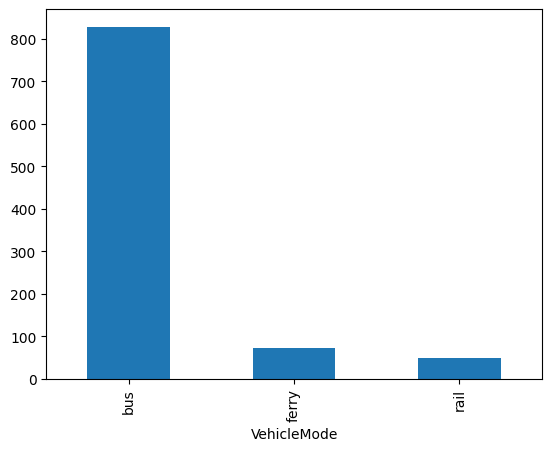

In [7]:
df["VehicleMode"].value_counts().plot.bar()

<Axes: xlabel='DataSource'>

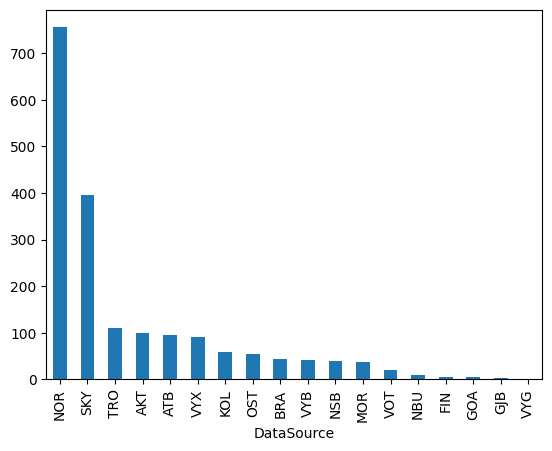

In [8]:
df["DataSource"].value_counts().plot.bar()